# Imports

In [1]:
import argparse, os
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import time

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

/home/aditya/anaconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CALLS FROM TERMINAL
# python ridge.py --target c --roi ventral --subject subj01
# python ridge.py --target init_latent --roi early --subject subj01

# Autoencoder

In [3]:
# Define a more complex autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size, weight_decay=1e-4):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, encoding_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 2500),
            nn.ReLU(),
            nn.Linear(2500, input_size)
        )
        
        # Add L2 regularization to the linear layers
        self.regularization = nn.MSELoss(reduction='sum')
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def calculate_regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += self.regularization(param, torch.zeros_like(param))
        return self.weight_decay * reg_loss
        #return 0.0

# FUNCTIONS

In [4]:
def evaluate_loss(model, loader, criterion, enc_dec):

    model.eval()

    with torch.no_grad():

        total_loss = 0 
        for batch in loader:

            # batch is a tuple, where batch[0] is X and batch[1] is Y
            x_batch, y_batch = batch
            
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            y_pred = model(x_batch)
            
            y_batch = enc_dec.encoder(y_batch)
            
            
            # Compute the loss MSE
            loss_mse = criterion(y_pred, y_batch)
            total_loss += loss_mse.item()*len(x_batch)

        

    model.train()
    total_loss = total_loss/(len(loader.dataset))
    total_loss = round(total_loss,8)
    
    return total_loss


In [5]:
def plot_losses(train_loss_list, val_loss_list):

    plt.figure(figsize=(10, 5))
    
    
    plt.plot(np.array(range(len(train_loss_list)))+1, np.array(train_loss_list), marker='o',
             color='limegreen', label='Train Loss', markeredgecolor='k', markersize=5)
    plt.plot(np.array(range(len(val_loss_list)))+1, np.array(val_loss_list), marker='o', 
             color='darkorange', label='Val Loss', markeredgecolor='k', markersize=5)

    
    plt.xticks(np.array(range(len(train_loss_list)))+1)

    #plt.xticks(np.)
    plt.grid()
    plt.legend(fontsize=15)
    plt.title('Loss vs Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)

# SETUP

In [6]:
# 1st CODE
# target = 'c'
# roi = 'ventral'
# subject = 'subj01'
# enc_dec = torch.load('autoencoder_c_ventral.pth')

# 2nd CODE
target = 'init_latent'
roi = 'early'
subject = 'subj01'
enc_dec = torch.load('autoencoder_init_latent_early.pth')



mridir = f'../../mrifeat/{subject}/'
featdir = '../../nsdfeat/subjfeat/'

# FOR THE MODEL IN PAPER 
# savedir = f'../..//decoded/{subject}/'

# FOR OUR L1 MODEL
savedir = f'../../decoded_l1/{subject}/'
os.makedirs(savedir, exist_ok=True)

In [7]:
# # if target == 'c' or target == 'init_latent': # CVPR
# #     alpha = [0.000001,0.00001,0.0001,0.001,0.01, 0.1, 1]
 
# # For experimentations
# if target == 'c' or target == 'init_latent': # CVPR
#     alpha = [0.01]

# LOAD DATA

In [8]:
X = []
X_te = []

for croi in [roi]:
    if 'conv' in target: # We use averaged features for GAN due to large number of dimension of features
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_ave_tr.npy').astype("float32")
    else:
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_tr.npy').astype("float32")
    
    cX_te = np.load(f'{mridir}/{subject}_{croi}_betas_ave_te.npy').astype("float32")
    
    X.append(cX)
    X_te.append(cX_te)

X = np.hstack(X)
X_te = np.hstack(X_te)


Y = np.load(f'{featdir}/{subject}_each_{target}_tr.npy').astype("float32").reshape([24980,-1])
Y_te = np.load(f'{featdir}/{subject}_ave_{target}_te.npy').astype("float32").reshape([X_te.shape[0],-1])

In [9]:
print(f'Now making decoding model for... {subject}:  {roi}, {target}')
print(f'X {X.shape}, Y {Y.shape}, X_te {X_te.shape}, Y_te {Y_te.shape}')

Now making decoding model for... subj01:  early, init_latent
X (24980, 5917), Y (24980, 6400), X_te (982, 5917), Y_te (982, 6400)


______
_____

In [10]:
# !nvidia-smi

# MODEL

In [11]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on your data and transform it

X = scaler.fit_transform(X)

y_mean = np.mean(Y, axis=0)
y_std = np.std(Y, axis=0)
#Y = scaler.fit_transform(Y)

X_te = scaler.fit_transform(X_te)
#Y_te = scaler.fit_transform(Y_te)

In [12]:
X.shape, Y.shape

((24980, 5917), (24980, 6400))

In [13]:
# Convert NumPy arrays to PyTorch tensors
X_tensor_train = torch.tensor(X, dtype=torch.float16)
Y_tensor_train = torch.tensor(Y, dtype=torch.float16)

X_tensor_test = torch.tensor(X_te, dtype=torch.float16)
Y_tensor_test = torch.tensor(Y_te, dtype=torch.float16)

# Create a TensorDataset from the tensors
train_dataset = TensorDataset(X_tensor_train, Y_tensor_train)
test_dataset = TensorDataset(X_tensor_test, Y_tensor_test)

# Set batch size for DataLoader
batch_size = 1024
# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Set input and output dimensions
input_dim = X.shape[1] # 7604
output_dim = Y.shape[1] # 59136
# Training loop
num_epochs = 1




del X
del X_te
del Y
del Y_te

In [14]:
# Define the Ridge Regression model
net = nn.Sequential(
                    nn.Linear(X_tensor_train.shape[1], 10000),
                    nn.ReLU(),
                    nn.Linear(10000, 1000)
                    )
net = net.half()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = net.to(device)

enc_dec.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=6400, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=2500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2500, out_features=6400, bias=True)
  )
  (regularization): MSELoss()
)

# TRAINING

In [15]:
!nvidia-smi

Tue Nov 28 23:14:36 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 L...    On | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0               24W /  80W|   1753MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
# Criterion and Optimiser
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=.1)

In [17]:
tic = time.time()


best_loss = float('inf')
PATIENCE = 3
loss_per=100

train_losses = []
test_losses = []
num_epochs = 800


for epoch in range(num_epochs):

    total_loss = 0 
    #print(f"Starting Epoch : {epoch+1} ")
    #print(f"\tProcessing BATCH   ", end='')
    for batch_idx, batch in enumerate(train_dataloader):

        #print(f"{batch_idx+1} ", end='')
        # batch is a tuple, where batch[0] is X and batch[1] is Y
        x_batch, y_batch = batch
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        # Forward pass
        y_pred = net(x_batch)

        y_batch = enc_dec.encoder(y_batch).detach()
            
        # Compute the loss with L1 regularization
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    train_loss = evaluate_loss(model=net, loader=train_dataloader, 
                               criterion=criterion, enc_dec=enc_dec)
    train_losses.append(train_loss)

    ########## VALIDATION LOSS ###########
    test_loss = evaluate_loss(model=net, loader=test_dataloader, 
                              criterion=criterion, enc_dec=enc_dec)
    test_losses.append(test_loss)

    print(f"\tEpoch {epoch +1} Train Loss : {train_loss}  | Test Loss : {test_loss}")
    
    
#     if epoch>0:
#         loss_per = ((old_loss-test_loss)/old_loss)*100
    
    if test_loss < best_loss:
        
        # SAVE BEST PARAMETERS
        best_params = net.state_dict()
        best_loss = test_loss
        patience_counter=0
        
    else:
        
        patience_counter +=1
        
#     old_loss = test_loss
    if patience_counter >= PATIENCE: # or abs(loss_per)<.05:
        print(f"\n\n BREAKING AT EPOCH {epoch+1}")
        break


tok = time.time()
print(tok-tic)
    
    
        

	Epoch 1 Train Loss : 3.08975712  | Test Loss : 2.87304688
	Epoch 2 Train Loss : 3.04759995  | Test Loss : 2.81835938
	Epoch 3 Train Loss : 3.01468988  | Test Loss : 2.7734375
	Epoch 4 Train Loss : 2.9857192  | Test Loss : 2.73828125
	Epoch 5 Train Loss : 2.96019566  | Test Loss : 2.70703125
	Epoch 6 Train Loss : 2.93753315  | Test Loss : 2.6796875
	Epoch 7 Train Loss : 2.91785491  | Test Loss : 2.65820312
	Epoch 8 Train Loss : 2.89961844  | Test Loss : 2.640625
	Epoch 9 Train Loss : 2.8827243  | Test Loss : 2.62304688
	Epoch 10 Train Loss : 2.86744239  | Test Loss : 2.60742188
	Epoch 11 Train Loss : 2.85275408  | Test Loss : 2.59375
	Epoch 12 Train Loss : 2.83873849  | Test Loss : 2.578125
	Epoch 13 Train Loss : 2.82520016  | Test Loss : 2.56640625
	Epoch 14 Train Loss : 2.8117397  | Test Loss : 2.5546875
	Epoch 15 Train Loss : 2.79896104  | Test Loss : 2.54296875
	Epoch 16 Train Loss : 2.7860626  | Test Loss : 2.53125
	Epoch 17 Train Loss : 2.77350443  | Test Loss : 2.52148438
	Epoch

# Prediction & Saving results

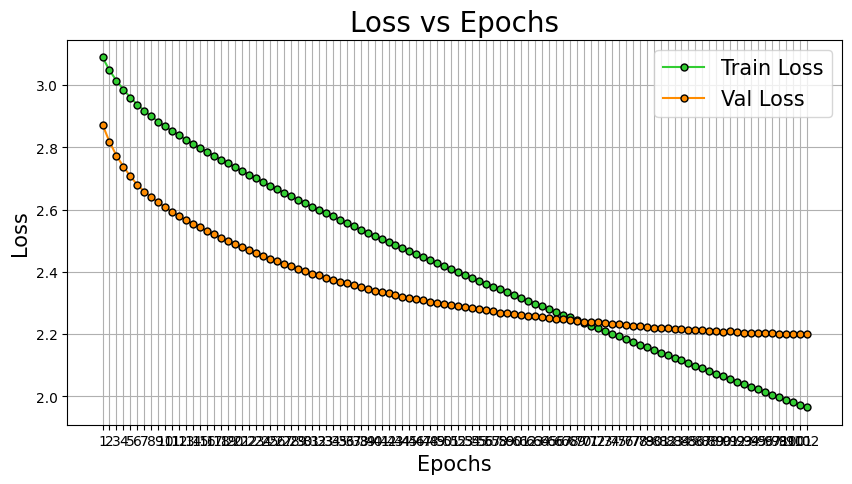

In [18]:
plot_losses(train_losses, test_losses)

In [19]:
net.eval()
with torch.no_grad():
    scores = enc_dec.decoder(net(X_tensor_test.to(device)))
    scores = scores.to('cpu').numpy()
net.train()

np.save(f'{savedir}/{subject}_{roi}_scores_{target}.npy',scores)

_____________________